# 实验大作业




导入库文件

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import comtheory as ct
from scipy.io import wavfile
import pygame
import os
import scipy .signal as signal
from scipy.signal import firwin, lfilter

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定字体
plt.rcParams['axes.unicode_minus'] = False             # 解决负号显示问题"

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


1. 信源

In [5]:
#导入音频
import_audio_rate, import_audio_data = wavfile.read('天雷滚滚.wav')
audio_data1 = import_audio_data[import_audio_rate:6*import_audio_rate,0]
audio_data2 = import_audio_data[import_audio_rate:6*import_audio_rate,1]


#导入数据
if not os.path.exists('bitstream.bin'):  # 检查文件是否存在
    print("文件不存在，请先生成比特序列并保存到本地文件")
else:  # 从本地文件读取比特流  
    with open('bitstream.bin', 'rb') as f:
        imported_bitstream = f.read()
bit_data = []
for byte in imported_bitstream:
    binary_str = bin(byte)[2:].zfill(8)   #将每个字节转换为二进制字符串，然后去掉前缀 '0b'，并填充到8位
    bit_data.extend([int(bit) for bit in binary_str])    #将二进制字符串转换为列表，并将字符转换为整数

#定义时间轴t和频率轴f
Fs = import_audio_rate
dt = 1/Fs
T_obs = len(audio_data1)*dt  #5s
t=np.arange(0,T_obs,dt)
N_obs = len(t)
df =1/T_obs
f=np.arange(-N_obs/2*df,N_obs/2*df,df)


#需要传输的原始音频数据：audio_data1，audio_data2
#需要传输的比特数据：bit_data

2. 发送端

In [7]:
# ====================================
# 音频下采样
# ====================================

# 原始采样率
Fs_original = import_audio_rate
# 目标采样率（原始的四分之一）
Fs_down = Fs_original // 4

print(f"原始音频采样率: {Fs_original} Hz")
print(f"目标下采样率: {Fs_down} Hz")

# 采样前音频数据类型
print(f"下采样前 audio_data1 数据类型: {audio_data1.dtype}")
print(f"下采样前 audio_data2 数据类型: {audio_data2.dtype}")

# 计算下采样后的样本数
# N_down = round(len(audio_data1) * (Fs_down / Fs_original))
# scipy.signal.resample 函数可以直接根据目标采样点数进行重采样
# 对于resample，目标点数是 (原始点数 * 目标采样率 / 原始采样率)
num_samples_down = int(len(audio_data1) * (Fs_down / Fs_original))

# 对左右声道进行下采样
# 使用 scipy.signal.resample 函数，它在频域进行重采样，效果较好
audio_data1_downsampled = signal.resample(audio_data1, num_samples_down)
audio_data2_downsampled = signal.resample(audio_data2, num_samples_down)

# 采样后音频数据类型
print(f"下采样后 audio_data1_downsampled 数据类型: {audio_data1_downsampled.dtype}")
print(f"下采样后 audio_data2_downsampled 数据类型: {audio_data2_downsampled.dtype}")

# 更新时间轴和频率轴参数以适应新的采样率
T_obs_downsampled = len(audio_data1_downsampled) * (1 / Fs_down)
t_downsampled = np.arange(0, T_obs_downsampled, 1/Fs_down)
N_obs_downsampled = len(t_downsampled)
df_downsampled = 1 / T_obs_downsampled
f_downsampled = np.arange(-N_obs_downsampled / 2 * df_downsampled, N_obs_downsampled / 2 * df_downsampled, df_downsampled)

print(f"下采样后音频数据长度 (声道1): {len(audio_data1_downsampled)}")
print(f"下采样后音频数据长度 (声道2): {len(audio_data2_downsampled)}")
print(f"下采样后时间轴长度: {len(t_downsampled)}")

原始音频采样率: 44100 Hz
目标下采样率: 11025 Hz
下采样前 audio_data1 数据类型: int16
下采样前 audio_data2 数据类型: int16
下采样后 audio_data1_downsampled 数据类型: float64
下采样后 audio_data2_downsampled 数据类型: float64
下采样后音频数据长度 (声道1): 55125
下采样后音频数据长度 (声道2): 55125
下采样后时间轴长度: 55125


In [8]:
# ====================================
# 音频数据量化与比特序列转换
# ====================================

# 确定量化位数
quantization_bits = 16 # 假设量化为16位，与原始音频一致

# 将浮点音频数据转换为整数类型（例如 int16），并进行归一化
# scipy.signal.resample 的输出是浮点数，通常范围在 -1.0 到 1.0 之间（如果原始数据是归一化的）
# 如果原始数据是int16，其范围是 -32768 到 32767
# 我们需要将浮点数重新映射到 int16 的范围
max_val = np.iinfo(np.int16).max # int16 的最大值 32767
min_val = np.iinfo(np.int16).min # int16 的最小值 -32768

# 归一化到 -1.0 到 1.0 范围（如果尚未归一化）
# 找到下采样后音频数据的最大绝对值，用于归一化
max_abs_audio = np.max(np.abs(np.concatenate((audio_data1_downsampled, audio_data2_downsampled))))
if max_abs_audio > 0: # 避免除以零
    audio_data1_normalized = audio_data1_downsampled / max_abs_audio
    audio_data2_normalized = audio_data2_downsampled / max_abs_audio
else: # 如果音频是静音，则保持为零
    audio_data1_normalized = audio_data1_downsampled
    audio_data2_normalized = audio_data2_downsampled

# 将归一化后的浮点数缩放到 int16 的范围
audio_data1_quantized = (audio_data1_normalized * max_val).astype(np.int16)
audio_data2_quantized = (audio_data2_normalized * max_val).astype(np.int16)

print(f"下采样后 audio_data1_downsampled 数据类型: {audio_data1_downsampled.dtype}")
print(f"量化后 audio_data1_quantized 数据类型: {audio_data1_quantized.dtype}")

# 将量化后的整数音频数据转换为比特序列
# 优化：使用 numpy 的位操作和循环，避免Python列表的频繁append
audio_bitstream_list = []
# 预分配列表大小以提高效率
# 每个样本 16 位，两个声道，样本数 len(audio_data1_quantized)
total_audio_bits = 2 * len(audio_data1_quantized) * quantization_bits
audio_bitstream_list = [0] * total_audio_bits
idx = 0

for i in range(len(audio_data1_quantized)):
    # 获取左声道和右声道样本
    sample1 = audio_data1_quantized[i]
    sample2 = audio_data2_quantized[i]

    # 将16位整数转换为16位比特序列
    # 使用位操作提取每个位
    # 对于每个样本，先处理左声道，再处理右声道，实现交错
    for bit_pos in range(quantization_bits - 1, -1, -1): # 从最高位到最低位
        # 左声道
        audio_bitstream_list[idx] = (sample1 >> bit_pos) & 1
        idx += 1
        # 右声道
        audio_bitstream_list[idx] = (sample2 >> bit_pos) & 1
        idx += 1

audio_bitstream = np.array(audio_bitstream_list, dtype=np.uint8) # 转换为numpy数组，节省内存并提高操作效率

print(f"音频比特流长度 (未加扰): {len(audio_bitstream)} bits")
print(f"音频比特流 (未加扰) 前16位: {audio_bitstream[:16]}")

# ====================================
# 对音频比特流进行加扰
# ====================================

# 定义一个简单的加扰器（例如，一个线性反馈移位寄存器 LFSR）
# 这里使用一个简单的伪随机序列进行异或操作
# 实际应用中会使用标准化的多项式来生成伪随机序列
# 为了简化，我们生成一个与音频比特流长度相同的随机比特序列作为扰码
# 更好的做法是使用LFSR，但为了快速实现和理解，先用随机数
np.random.seed(42) # 为了结果可复现，设置随机种子
scrambler_sequence = np.random.randint(0, 2, size=len(audio_bitstream), dtype=np.uint8)

# 加扰：音频比特流与扰码进行异或操作
audio_bitstream_scrambled = np.logical_xor(audio_bitstream, scrambler_sequence).astype(np.uint8)

print(f"音频比特流长度 (加扰后): {len(audio_bitstream_scrambled)} bits")
print(f"音频比特流 (加扰后) 前16位: {audio_bitstream_scrambled[:16]}")

# 确保 bit_data 也是 numpy 数组以便后续操作一致
bit_data_np = np.array(bit_data, dtype=np.uint8)

# 最终的两个比特流：
# 1. bit_data_np (来自文件的数据比特流)
# 2. audio_bitstream_scrambled (量化、交错、加扰后的音频比特流)

print("\n====================================")
print("最终比特流长度验证:")
print(f"数据文件比特流长度: {len(bit_data_np)} bits")
print(f"数据文件比特流前16位: {bit_data_np[:16]}")

print(f"音频比特流长度: {len(audio_bitstream_scrambled)} bits")
print(f"音频比特流前16位: {audio_bitstream_scrambled[:16]}")
print("====================================")

下采样后 audio_data1_downsampled 数据类型: float64
量化后 audio_data1_quantized 数据类型: int16
音频比特流长度 (未加扰): 1764000 bits
音频比特流 (未加扰) 前16位: [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
音频比特流长度 (加扰后): 1764000 bits
音频比特流 (加扰后) 前16位: [0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0]

最终比特流长度验证:
数据文件比特流长度: 400000 bits
数据文件比特流前16位: [1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 0]
音频比特流长度: 1764000 bits
音频比特流前16位: [0 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0]


In [9]:
# ====================================
# 信道编码：(2,1,3) 卷积编码
# ====================================

# 定义卷积编码器函数
def convolutional_encode(input_bitstream):
    # 约束长度 K = 3，意味着有 K-1 = 2 个寄存器
    # 寄存器初始化为 0
    register_uj_1 = 0
    register_uj_2 = 0

    # 存储编码后的比特
    encoded_bitstream = []

    # 添加拖尾比特：K-1 个零比特
    # 这样可以确保编码器回到全零状态，方便维特比解码
    padded_input_bitstream = np.concatenate((input_bitstream, np.array([0, 0], dtype=np.uint8)))

    for uj in padded_input_bitstream:
        # 计算输出 c1j 和 c2j
        # G1 (111): uj + uj-1 + uj-2
        c1j = (uj + register_uj_1 + register_uj_2) % 2
        # G2 (101): uj + uj-2
        c2j = (uj + register_uj_2) % 2

        # 将输出比特添加到编码序列
        encoded_bitstream.append(c1j)
        encoded_bitstream.append(c2j)

        # 更新寄存器
        register_uj_2 = register_uj_1
        register_uj_1 = uj

    return np.array(encoded_bitstream, dtype=np.uint8)

# 对数据文件比特流进行卷积编码
data_encoded_bitstream = convolutional_encode(bit_data_np)

# 对加扰后的音频比特流进行卷积编码
audio_encoded_bitstream = convolutional_encode(audio_bitstream_scrambled)

print("\n====================================")
print("信道编码结果:")
print(f"原始数据文件比特流长度: {len(bit_data_np)} bits")
print(f"编码后数据文件比特流长度: {len(data_encoded_bitstream)} bits")
print(f"编码后数据文件比特流前16位: {data_encoded_bitstream[:16]}")

print(f"原始音频比特流长度: {len(audio_bitstream_scrambled)} bits")
print(f"编码后音频比特流长度: {len(audio_encoded_bitstream)} bits")
print(f"编码后音频比特流前16位: {audio_encoded_bitstream[:16]}")
print("====================================")


信道编码结果:
原始数据文件比特流长度: 400000 bits
编码后数据文件比特流长度: 800004 bits
编码后数据文件比特流前16位: [1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0]
原始音频比特流长度: 1764000 bits
编码后音频比特流长度: 3528004 bits
编码后音频比特流前16位: [0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0]


In [10]:
# ====================================
# 16QAM 星座映射（未归一化）
# ====================================

def bits_to_16qam_symbols_int(bitstream):
    """
    输入：bitstream（一维np.uint8数组，长度为4的倍数）
    输出：I分量数组，Q分量数组（均为int，星座取值-3,-1,+1,+3）
    """
    # 补齐为4的倍数
    pad_len = (4 - (len(bitstream) % 4)) % 4
    if pad_len > 0:
        bitstream = np.concatenate([bitstream, np.zeros(pad_len, dtype=np.uint8)])

    symbols = bitstream.reshape(-1, 4)

    # Gray码映射：00→-3, 01→-1, 11→+1, 10→+3
    gray_map = np.array([-3, -1, 3, 1], dtype=int)  # 00,01,10,11

    I_index = 2 * symbols[:,0] + symbols[:,1]
    Q_index = 2 * symbols[:,2] + symbols[:,3]

    I_val = gray_map[I_index]
    Q_val = gray_map[Q_index]

    return I_val, Q_val

# ====================================
# 对数据和音频比特流进行16QAM整数映射
# ====================================

data_I, data_Q = bits_to_16qam_symbols_int(data_encoded_bitstream)
audio_I, audio_Q = bits_to_16qam_symbols_int(audio_encoded_bitstream)

print("\n====================================")
print("16QAM整数星座映射结果:")
print(f"数据文件16QAM前5组: I={data_I[:5]}, Q={data_Q[:5]}")
print(f"音频16QAM前5组: I={audio_I[:5]}, Q={audio_Q[:5]}")
print("====================================")


16QAM整数星座映射结果:
数据文件16QAM前5组: I=[ 1  1  1 -3  1], Q=[ 3 -3  3  3 -3]
音频16QAM前5组: I=[-3  1  3 -1 -1], Q=[-3 -1  3 -3 -1]


RRC 脉冲响应的峰值: 0.2842


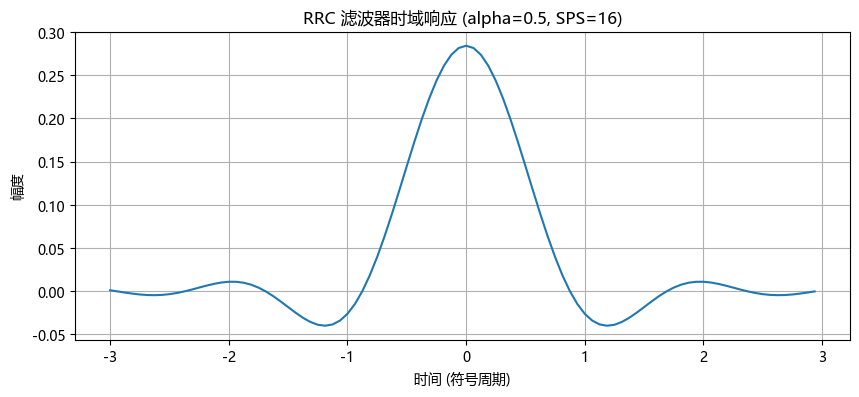

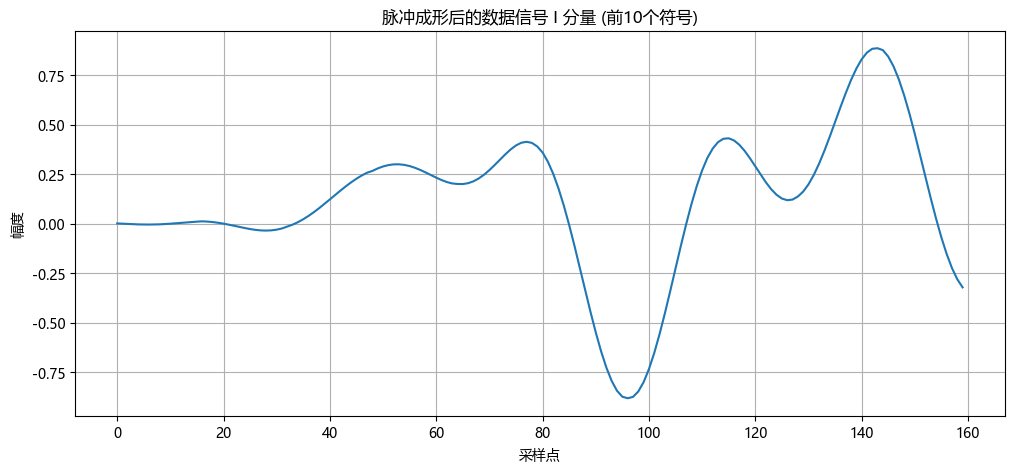

In [11]:
# ====================================
# 根升余弦脉冲成形 (Root Raised Cosine, RRC)
# ====================================

# 定义 RRC 滤波器参数
alpha = 0.5  # 滚降系数
SPS = 16     # 每个符号的采样点数 (Samples Per Symbol)
num_taps = SPS * 6 # 滤波器抽头数，通常取 SPS 的整数倍，这里取 6 个符号的长度

# 生成 RRC 滤波器
# RRC 滤波器函数 h(t) 的公式
# h(t) = (1/T_s) * [ (sin(pi * t / T_s * (1 - alpha)) + 4 * alpha * (t / T_s) * cos(pi * t / T_s * (1 + alpha))) / (pi * t / T_s * (1 - (4 * alpha * t / T_s)^2)) ]
# 当 t = 0 时，h(0) = (1/T_s) * (1 - alpha + 4*alpha) = (1/T_s) * (1 + 3*alpha)
# 当 t = +/- T_s / (4*alpha) 时，分母为零，需要使用洛必达法则或特殊处理
# 这里我们使用离散时间实现，t 变为 k*dt，其中 dt = 1/Fs_pulse = 1/(SPS * Rs)

# T_s 是符号周期，这里我们设为 1（归一化），则采样间隔为 1/SPS
t_rrc = np.arange(-num_taps // 2, num_taps // 2) / SPS

rrc_filter = np.zeros(len(t_rrc))

for i, t_val in enumerate(t_rrc):
    if t_val == 0:
        rrc_filter[i] = (1 / SPS) * (1 + alpha * (4/np.pi - 1)) # 更精确的 t=0 处的公式
    elif abs(abs(t_val) - 1 / (4 * alpha)) < 1e-9 and alpha != 0: # 避免除以零，当 t = +/- 1/(4*alpha)
        rrc_filter[i] = (alpha / (np.sqrt(2) * SPS)) * ((1 + 2/np.pi) * np.sin(np.pi / (4 * alpha)) + (1 - 2/np.pi) * np.cos(np.pi / (4 * alpha)))
    else:
        numerator = np.sin(np.pi * t_val * (1 - alpha)) + 4 * alpha * t_val * np.cos(np.pi * t_val * (1 + alpha))
        denominator = np.pi * t_val * (1 - (4 * alpha * t_val)**2)
        rrc_filter[i] = numerator / denominator / SPS

# 归一化 RRC 滤波器，使其能量为 1
rrc_filter = rrc_filter / np.sqrt(np.sum(rrc_filter**2))

# 计算 RRC 脉冲响应的峰值
rrc_peak_value = np.max(np.abs(rrc_filter))
print(f"RRC 脉冲响应的峰值: {rrc_peak_value:.4f}")


# 对 16QAM 符号进行脉冲成形
# 首先对符号进行上采样（在每个符号之间插入 SPS-1 个零）
def upsample_and_filter(symbols, rrc_filter, SPS):
    upsampled_symbols = np.zeros(len(symbols) * SPS, dtype=float)
    upsampled_symbols[::SPS] = symbols # 在每个符号位置放置符号值，其他位置为零
    filtered_signal = np.convolve(upsampled_symbols, rrc_filter, mode='full')
    # 卷积结果长度会变长，需要截取有效部分
    return filtered_signal[:len(symbols) * SPS] # 截取到原始符号数 * SPS 的长度

data_I_shaped = upsample_and_filter(data_I, rrc_filter, SPS)
data_Q_shaped = upsample_and_filter(data_Q, rrc_filter, SPS)
audio_I_shaped = upsample_and_filter(audio_I, rrc_filter, SPS)
audio_Q_shaped = upsample_and_filter(audio_Q, rrc_filter, SPS)


# 绘制 RRC 滤波器时域响应
plt.figure(figsize=(10, 4))
plt.plot(t_rrc, rrc_filter)
plt.title('RRC 滤波器时域响应 (alpha=0.5, SPS=16)')
plt.xlabel('时间 (符号周期)')
plt.ylabel('幅度')
plt.grid(True)
plt.show()

# 绘制脉冲成形后的信号 I 分量（以数据信号为例）
plt.figure(figsize=(12, 5))
plt.plot(data_I_shaped[:SPS*10]) # 绘制前10个符号的波形
plt.title('脉冲成形后的数据信号 I 分量 (前10个符号)')
plt.xlabel('采样点')
plt.ylabel('幅度')
plt.grid(True)
plt.show()

数据信号符号率 Rs_data: 40000.20 symbols/s
音频信号符号率 Rs_audio: 176400.20 symbols/s
调制后的信号采样率 Fs_mod: 2400000.0 Hz
调制后的信号总长度: 12000000 采样点
调制后的信号持续时间: 5.0000 秒


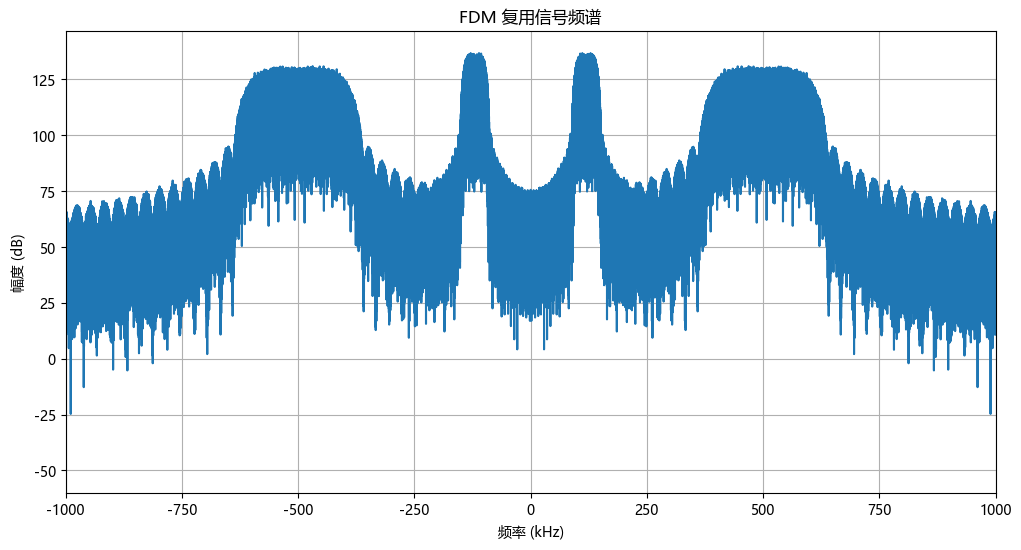

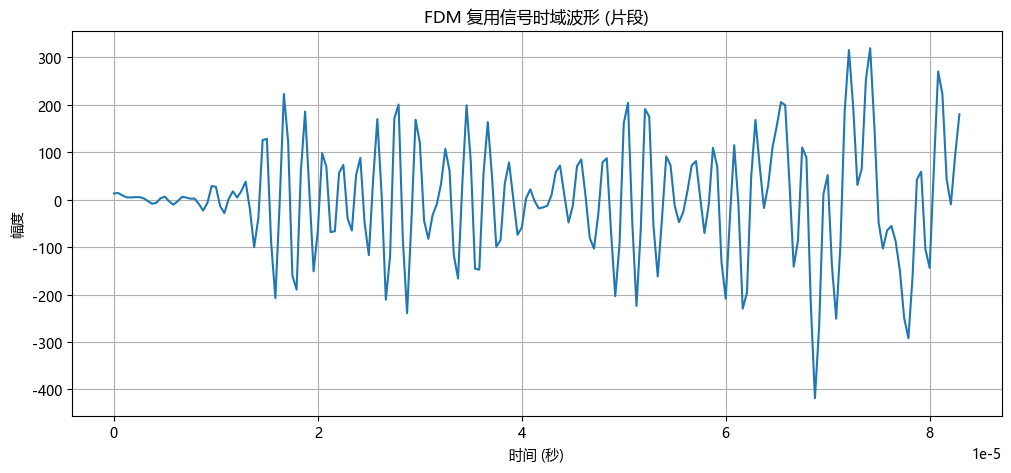

In [12]:
# ====================================
# IQ 调制和 FDM 复用
# ====================================

# 定义载波频率
fc_audio = 500e3  # 音频信号载波频率 500 kHz
fc_data = 120e3    # 数据信号载波频率 120 kHz

# 从题目和编码结果推导参数
# 总传输时间 T_total = 5 秒 (题目要求 5 秒内传完)

# 数据信号参数
# 编码后数据文件比特流长度: 800004 bits
encoded_data_bits_len = 800004
# 16QAM 每个符号携带 4 比特
Rs_data = encoded_data_bits_len / 4 / 5  # 符号率 = 编码比特数 / 4 / 总时间
print(f"数据信号符号率 Rs_data: {Rs_data:.2f} symbols/s")

# 音频信号参数
# 编码后音频比特流长度: 3528004 bits
encoded_audio_bits_len = 3528004
Rs_audio = encoded_audio_bits_len / 4 / 5 # 符号率 = 编码比特数 / 4 / 总时间
print(f"音频信号符号率 Rs_audio: {Rs_audio:.2f} symbols/s")


# 确定新的采样率 Fs_mod
# 脉冲成形后的信号采样率 = 符号率 * SPS
# 奈奎斯特采样定理要求采样率大于最高频率的两倍
# 16QAM 信号带宽约为 Rs * (1 + alpha)
# 数据信号带宽 BW_data = Rs_data * (1 + alpha)
# 音频信号带宽 BW_audio = Rs_audio * (1 + alpha)

# 计算调制后信号的最高频率
# 数据信号最高频率 = fc_data + BW_data / 2
# 音频信号最高频率 = fc_audio + BW_audio / 2
max_freq_data = fc_data + Rs_data * (1 + alpha) / 2
max_freq_audio = fc_audio + Rs_audio * (1 + alpha) / 2

# 确保 Fs_mod 至少是所有信号最高频率的两倍，并留有裕量
# 取一个足够大的值，例如 2 * (最高载波频率 + 最大信号半带宽) * 裕量因子
Fs_mod = 2.4e6

# 确保所有成形后的信号长度一致，并重新采样到 Fs_mod
# 计算原始成形信号的持续时间
# data_I_shaped 的长度是 len(data_I) * SPS
# data_I 的长度是 encoded_data_bits_len / 4
# 所以 data_I_shaped 的长度是 (encoded_data_bits_len / 4) * SPS
duration_data_shaped = len(data_I_shaped) / (Rs_data * SPS)
duration_audio_shaped = len(audio_I_shaped) / (Rs_audio * SPS)
# 理论上，由于都是 5 秒，这里应该都是 5 秒，但为了代码健壮性，取最大值
max_duration = max(duration_data_shaped, duration_audio_shaped)

# 计算新的样本点数
num_samples_mod = int(max_duration * Fs_mod)

# 对脉冲成形后的信号进行重采样，使其采样率统一为 Fs_mod
# 注意：resample 函数可能导致数据类型变化，通常输出浮点数
data_I_resampled = signal.resample(data_I_shaped, num_samples_mod)
data_Q_resampled = signal.resample(data_Q_shaped, num_samples_mod)
audio_I_resampled = signal.resample(audio_I_shaped, num_samples_mod)
audio_Q_resampled = signal.resample(audio_Q_shaped, num_samples_mod)

# 生成时间向量
t_mod = np.arange(num_samples_mod) / Fs_mod

# IQ 调制
# 数据信号调制
data_carrier_I = np.cos(2 * np.pi * fc_data * t_mod)
data_carrier_Q = -np.sin(2 * np.pi * fc_data * t_mod)

modulated_data_signal = data_I_resampled * data_carrier_I + data_Q_resampled * data_carrier_Q

# 音频信号调制
audio_carrier_I = np.cos(2 * np.pi * fc_audio * t_mod)
audio_carrier_Q = -np.sin(2 * np.pi * fc_audio * t_mod)

modulated_audio_signal = audio_I_resampled * audio_carrier_I + audio_Q_resampled * audio_carrier_Q

# FDM 复用：简单相加
Tx_signal = modulated_data_signal + modulated_audio_signal
Tx_signal *= 200
#先放大100倍
print(f"调制后的信号采样率 Fs_mod: {Fs_mod} Hz")
print(f"调制后的信号总长度: {len(Tx_signal)} 采样点")
print(f"调制后的信号持续时间: {len(Tx_signal)/Fs_mod:.4f} 秒")


# 绘图验证：绘制复用信号的频谱
N_fft = len(Tx_signal)
Tx_signal_fft = np.fft.fft(Tx_signal)
Tx_signal_fft_shifted = np.fft.fftshift(Tx_signal_fft)
frequencies = np.fft.fftshift(np.fft.fftfreq(N_fft, d=1/Fs_mod))

plt.figure(figsize=(12, 6))
plt.plot(frequencies / 1e3, 20 * np.log10(np.abs(Tx_signal_fft_shifted) + 1e-10))
plt.title('FDM 复用信号频谱')
plt.xlabel('频率 (kHz)')
plt.ylabel('幅度 (dB)')
plt.grid(True)
plt.xlim([-1000, 1000])
plt.ylim([-60, max(20 * np.log10(np.abs(Tx_signal_fft_shifted))) + 10])
plt.show()

# 绘制时域信号片段
plt.figure(figsize=(12, 5))
# 绘制足够长的片段以看到两个载波的叠加效果，例如 10 个数据信号周期
plot_duration = 10 / fc_data # 10 个数据信号周期
plot_samples = int(plot_duration * Fs_mod)
plt.plot(t_mod[:plot_samples], Tx_signal[:plot_samples])
plt.title('FDM 复用信号时域波形 (片段)')
plt.xlabel('时间 (秒)')
plt.ylabel('幅度')
plt.grid(True)
plt.show()

3. 信道

信道衰减因子: 0.0100
信道噪声带宽: 2000.0 kHz
信道噪声功率: 2.00e-03 W
信道噪声标准差: 4.47e-02


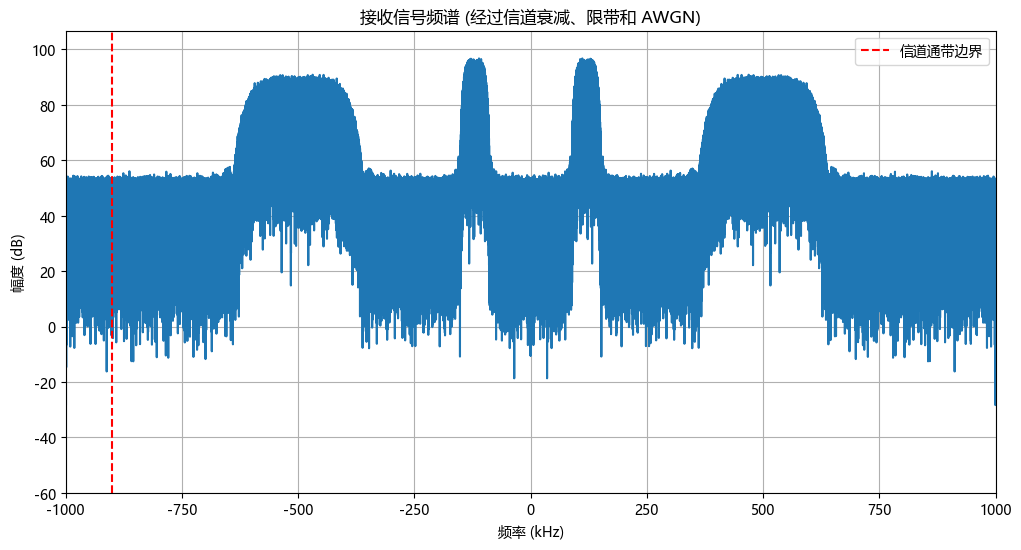

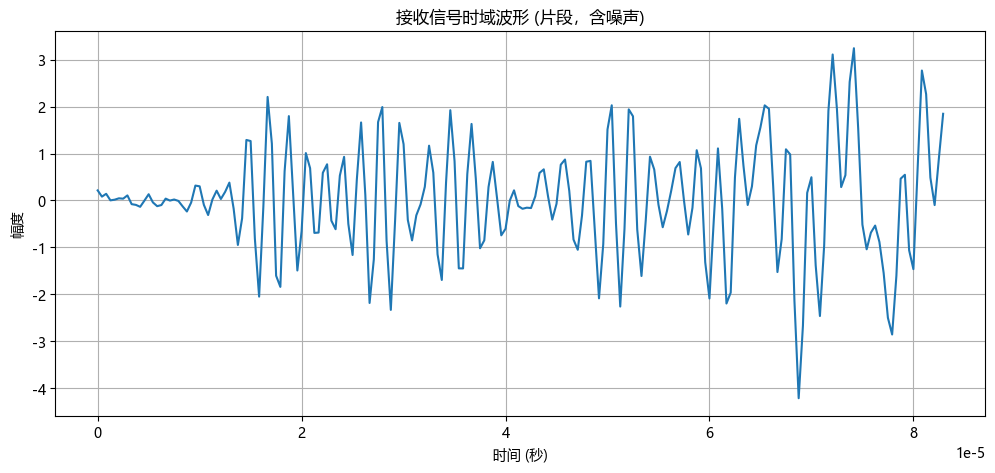

In [14]:
# ====================================
# 信道模拟
# ====================================

# 信道参数
channel_attenuation_dB = 20  # 信道衰减 20 dB
N0 = 10e-10               # AWGN 噪声功率谱密度 N0 = 10^-10 W/Hz
channel_low_freq = -900e3    # 信道通频范围低频端 -900 kHz
channel_high_freq = 1100e3   # 信道通频范围高频端 1100 kHz

# 1. 信道衰减
# 将 dB 转换为线性幅度衰减因子
attenuation_factor = 0.01
Rx_signal_attenuated = Tx_signal * attenuation_factor

# 2. 理想限带信道模拟 (理想带通滤波器)
# 在频域实现理想带通滤波
Rx_signal_fft = np.fft.fft(Rx_signal_attenuated)
frequencies_fft = np.fft.fftfreq(len(Rx_signal_attenuated), d=1/Fs_mod)

# 创建理想带通滤波器掩码
# 注意：FFT 频率的排列方式，0 Hz 在中间，负频率在右侧
# 使用 np.fft.fftshift 后的频率轴来判断
frequencies_shifted = np.fft.fftshift(frequencies_fft)
Rx_signal_fft_shifted = np.fft.fftshift(Rx_signal_fft)

# 滤波器掩码：在通带内为1，通带外为0
filter_mask = np.logical_and(frequencies_shifted >= channel_low_freq,
                             frequencies_shifted <= channel_high_freq)

# 应用滤波器
Rx_signal_fft_filtered_shifted = Rx_signal_fft_shifted * filter_mask
Rx_signal_fft_filtered = np.fft.ifftshift(Rx_signal_fft_filtered_shifted)

# 傅里叶逆变换回到时域
Rx_signal_filtered = np.fft.ifft(Rx_signal_fft_filtered).real # 取实部，因为输入是实数信号

# 3. 添加 AWGN 噪声
# 计算噪声功率
# 噪声带宽 B 是信道的通带带宽
noise_bandwidth = channel_high_freq - channel_low_freq # 1100 kHz - (-900 kHz) = 2000 kHz = 2 MHz
noise_power = N0 * noise_bandwidth
# 噪声标准差 (均方根值)
# 噪声是实数信号，所以功率是 sigma^2，而不是 2*sigma^2
# 噪声的方差 (sigma^2) 等于噪声功率
noise_std_dev = np.sqrt(noise_power)

# 生成高斯白噪声
# 噪声的长度应与信号长度相同
# 噪声的采样率与信号采样率相同
noise = np.random.normal(0, noise_std_dev, len(Rx_signal_filtered))

# 将噪声添加到信号中
Rx_signal = Rx_signal_filtered + noise

print(f"信道衰减因子: {attenuation_factor:.4f}")
print(f"信道噪声带宽: {noise_bandwidth / 1e3} kHz")
print(f"信道噪声功率: {noise_power:.2e} W")
print(f"信道噪声标准差: {noise_std_dev:.2e}")


# 绘图验证：绘制接收信号的频谱（带噪声和衰减）
N_fft_rx = len(Rx_signal)
Rx_signal_fft = np.fft.fft(Rx_signal)
Rx_signal_fft_shifted = np.fft.fftshift(Rx_signal_fft)
frequencies_rx = np.fft.fftshift(np.fft.fftfreq(N_fft_rx, d=1/Fs_mod))

plt.figure(figsize=(12, 6))
plt.plot(frequencies_rx / 1e3, 20 * np.log10(np.abs(Rx_signal_fft_shifted) + 1e-10))
plt.title('接收信号频谱 (经过信道衰减、限带和 AWGN)')
plt.xlabel('频率 (kHz)')
plt.ylabel('幅度 (dB)')
plt.grid(True)
plt.xlim([-1000, 1000]) # 观察整个信道带宽
plt.ylim([-60, max(20 * np.log10(np.abs(Rx_signal_fft_shifted))) + 10])
plt.axvline(channel_low_freq / 1e3, color='r', linestyle='--', label='信道通带边界')
plt.axvline(channel_high_freq / 1e3, color='r', linestyle='--')
plt.legend()
plt.show()

# 绘制接收信号时域波形片段
plt.figure(figsize=(12, 5))
plot_duration_rx = 10 / fc_data # 10 个数据信号周期
plot_samples_rx = int(plot_duration_rx * Fs_mod)
plt.plot(t_mod[:plot_samples_rx], Rx_signal[:plot_samples_rx])
plt.title('接收信号时域波形 (片段，含噪声)')
plt.xlabel('时间 (秒)')
plt.ylabel('幅度')
plt.grid(True)
plt.show()

4. 接收端

数据信号带通滤波器截止频率: 70.0 kHz - 170.0 kHz
音频信号带通滤波器截止频率: 350.0 kHz - 650.0 kHz


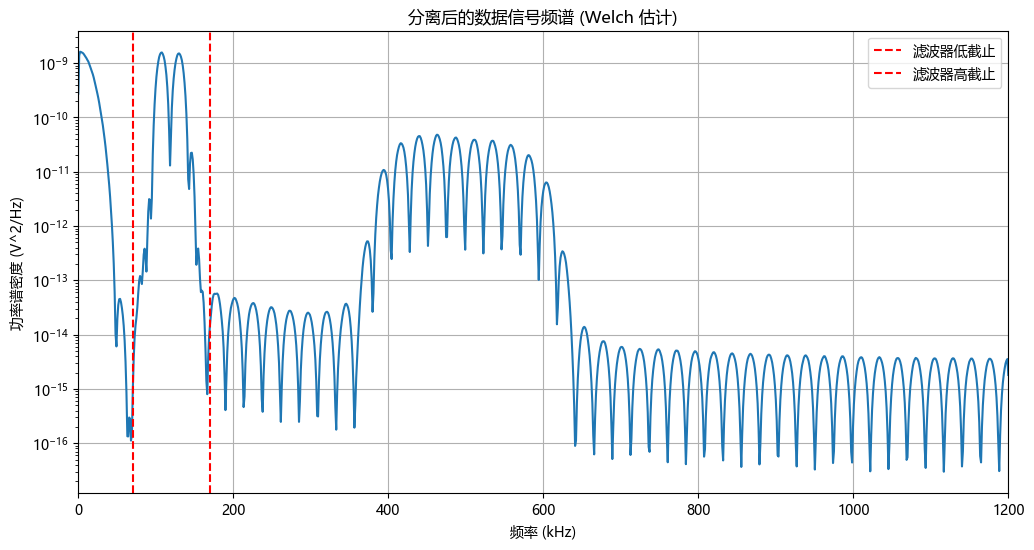

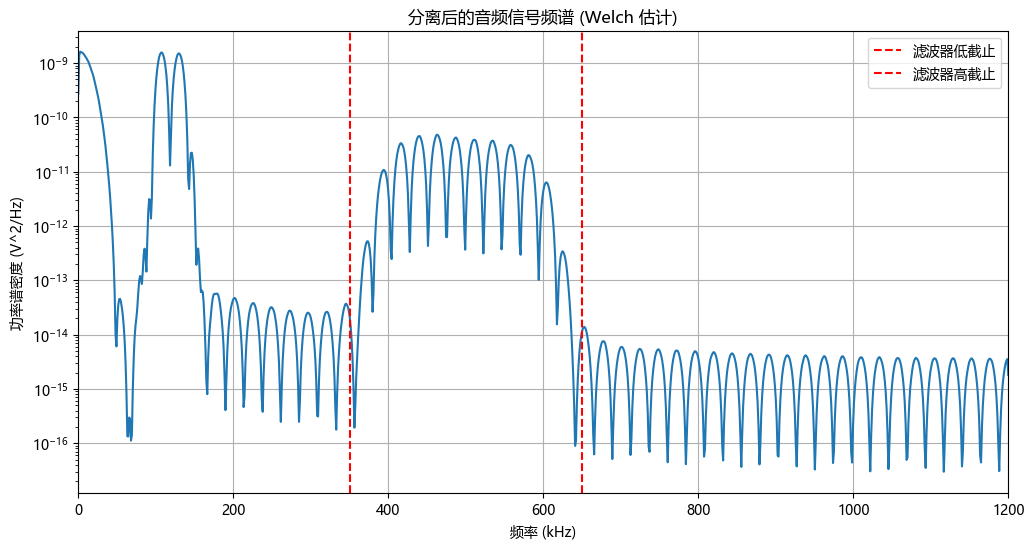

In [16]:
# ====================================
# FDM 解复用
# ====================================

# 更新的载波频率（与发送端保持一致）
fc_audio_rx = 500e3  # 音频信号载波频率 500 kHz
fc_data_rx = 120e3    # 数据信号载波频率 120 kHz

# 信号带宽（用于滤波器设计）
# 这些是调制后信号的单边带宽，即基带带宽 Rs * (1+alpha) / 2
# 或者直接使用您给出的总带宽的一半
BW_audio_total = 300e3 # 音频信号总带宽 300 kHz
BW_data_total = 100e3  # 数据信号总带宽 100 kHz

# 1. 解复用：带通滤波分离信号

# FIR 滤波器设计参数
num_taps_filter = 101 # 滤波器抽头数，影响滤波器的陡峭程度和计算量，通常取奇数
# 过渡带宽可以根据实际需求调整，这里设置为信号带宽的10%左右
transition_bandwidth_audio = 0.1 * BW_audio_total
transition_bandwidth_data = 0.1 * BW_data_total

# 设计数据信号的带通滤波器
# 截止频率：fc_data_rx +/- BW_data_total / 2
data_filter_lowcut = fc_data_rx - BW_data_total / 2
data_filter_highcut = fc_data_rx + BW_data_total / 2
# firwin 的截止频率是归一化的 (0到1，对应0到Fs_mod/2)
nyquist_freq = Fs_mod / 2
b_data = signal.firwin(num_taps_filter,
                       [data_filter_lowcut / nyquist_freq, data_filter_highcut / nyquist_freq],
                       pass_zero=False, fs=Fs_mod) # pass_zero=False 表示带通

# 设计音频信号的带通滤波器
# 截止频率：fc_audio_rx +/- BW_audio_total / 2
audio_filter_lowcut = fc_audio_rx - BW_audio_total / 2
audio_filter_highcut = fc_audio_rx + BW_audio_total / 2
b_audio = signal.firwin(num_taps_filter,
                        [audio_filter_lowcut / nyquist_freq, audio_filter_highcut / nyquist_freq],
                        pass_zero=False, fs=Fs_mod)

# 应用滤波器
Rx_signal_data_filtered = signal.lfilter(b_data, 1, Rx_signal)
Rx_signal_audio_filtered = signal.lfilter(b_audio, 1, Rx_signal)

# 2. 下变频 (解调)
# 生成下变频载波
# 注意：解调载波的相位和频率需要与发送端严格同步，这里假设理想同步
data_demod_carrier_I = np.cos(2 * np.pi * fc_data_rx * t_mod)
data_demod_carrier_Q = np.sin(2 * np.pi * fc_data_rx * t_mod) # 注意这里是 +sin，因为发送端是 -sin

audio_demod_carrier_I = np.cos(2 * np.pi * fc_audio_rx * t_mod)
audio_demod_carrier_Q = np.sin(2 * np.pi * fc_audio_rx * t_mod) # 注意这里是 +sin

# 数据信号下变频
# 乘以解调载波
demod_data_I_raw = Rx_signal_data_filtered * data_demod_carrier_I
demod_data_Q_raw = Rx_signal_data_filtered * data_demod_carrier_Q

# 音频信号下变频
demod_audio_I_raw = Rx_signal_audio_filtered * audio_demod_carrier_I
demod_audio_Q_raw = Rx_signal_audio_filtered * audio_demod_carrier_Q

# 下变频后需要低通滤波以滤除 2fc 频率分量，得到基带信号
# 基带信号的带宽是 BW_data_total / 2 和 BW_audio_total / 2
# 设计低通滤波器
# 数据信号基带低通滤波器
b_data_lp = signal.firwin(num_taps_filter, (BW_data_total / 2) / nyquist_freq, fs=Fs_mod)
# 音频信号基带低通滤波器
b_audio_lp = signal.firwin(num_taps_filter, (BW_audio_total / 2) / nyquist_freq, fs=Fs_mod)

# 应用低通滤波器
demod_data_I = signal.lfilter(b_data_lp, 1, demod_data_I_raw) * 2 # 乘以2补偿解调过程的幅度衰减
demod_data_Q = signal.lfilter(b_data_lp, 1, demod_data_Q_raw) * 2

demod_audio_I = signal.lfilter(b_audio_lp, 1, demod_audio_I_raw) * 2
demod_audio_Q = signal.lfilter(b_audio_lp, 1, demod_audio_Q_raw) * 2


print(f"数据信号带通滤波器截止频率: {data_filter_lowcut/1e3:.1f} kHz - {data_filter_highcut/1e3:.1f} kHz")
print(f"音频信号带通滤波器截止频率: {audio_filter_lowcut/1e3:.1f} kHz - {audio_filter_highcut/1e3:.1f} kHz")


# 绘图验证：使用 Welch 估计绘制分离后的信号频谱
# 数据信号频谱
plt.figure(figsize=(12, 6))
f_data_psd, Pxx_data_psd = signal.welch(Rx_signal_data_filtered, Fs_mod, nperseg=2048)
plt.semilogy(f_data_psd / 1e3, Pxx_data_psd) # 使用 semilogy 绘制功率谱密度
plt.title('分离后的数据信号频谱 (Welch 估计)')
plt.xlabel('频率 (kHz)')
plt.ylabel('功率谱密度 (V^2/Hz)')
plt.grid(True)
plt.xlim([0, Fs_mod / 2 / 1e3]) # 只显示正频率
plt.axvline(data_filter_lowcut / 1e3, color='r', linestyle='--', label='滤波器低截止')
plt.axvline(data_filter_highcut / 1e3, color='r', linestyle='--', label='滤波器高截止')
plt.legend()
plt.show()

# 音频信号频谱
plt.figure(figsize=(12, 6))
f_audio_psd, Pxx_audio_psd = signal.welch(Rx_signal_audio_filtered, Fs_mod, nperseg=2048)
plt.semilogy(f_audio_psd / 1e3, Pxx_audio_psd)
plt.title('分离后的音频信号频谱 (Welch 估计)')
plt.xlabel('频率 (kHz)')
plt.ylabel('功率谱密度 (V^2/Hz)')
plt.grid(True)
plt.xlim([0, Fs_mod / 2 / 1e3])
plt.axvline(audio_filter_lowcut / 1e3, color='r', linestyle='--', label='滤波器低截止')
plt.axvline(audio_filter_highcut / 1e3, color='r', linestyle='--', label='滤波器高截止')
plt.legend()
plt.show()

RC 滤波器 (两个 RRC 卷积) 的峰值: 1.0000


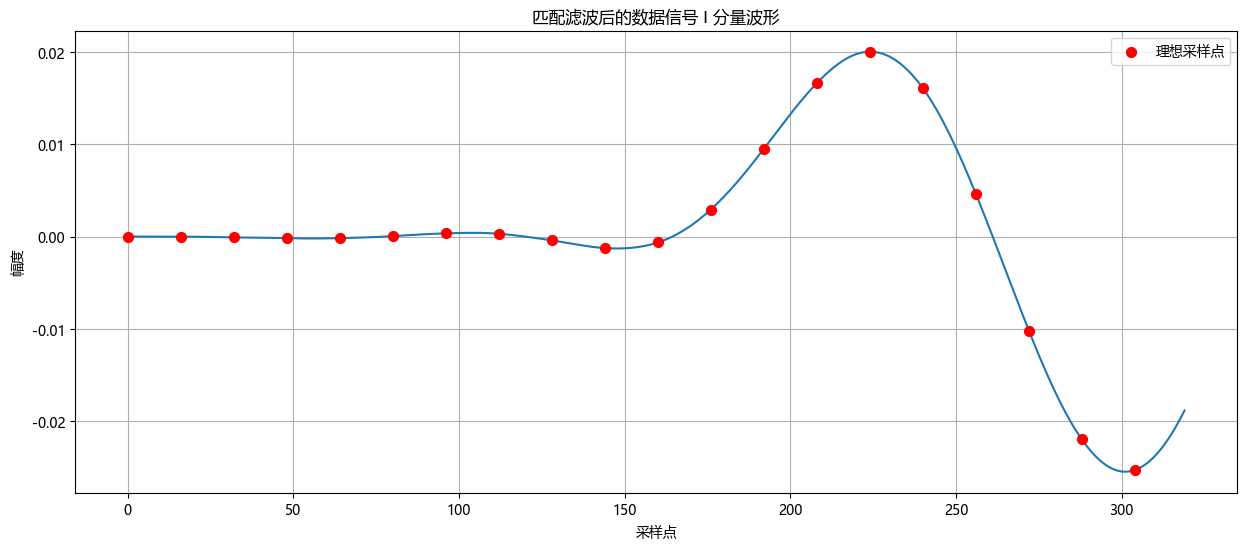

In [17]:
# ====================================
# RCC 匹配滤波
# ====================================

# 匹配滤波器的脉冲响应是发送端 RRC 滤波器的时域反转
# 由于 RRC 滤波器是实对称的，其时域反转就是它本身
rrc_matched_filter = rrc_filter

# 额外计算两个 RRC 滤波器脉冲响应匹配滤波的结果的峰值
# 两个 RRC 滤波器匹配滤波，相当于一个升余弦 (RC) 滤波器
# RC 滤波器的脉冲响应是两个 RRC 滤波器卷积的结果
# 理论上，RC 滤波器在 t=0 处有最大峰值

# 计算两个 RRC 滤波器脉冲响应的卷积 (得到 RC 滤波器)
rc_filter = np.convolve(rrc_filter, rrc_matched_filter, mode='full')

# 找到 RC 滤波器的峰值
rc_filter_peak = np.max(np.abs(rc_filter)) # 取绝对值峰值

print(f"RC 滤波器 (两个 RRC 卷积) 的峰值: {rc_filter_peak:.4f}")

# 对解调后的基带信号进行匹配滤波
# 这里以 demod_data_I 和 demod_data_Q 为例

# 匹配滤波
Rx_data_I_mf = np.convolve(demod_data_I, rrc_matched_filter, mode='full')
Rx_data_Q_mf = np.convolve(demod_data_Q, rrc_matched_filter, mode='full')

Rx_audio_I_mf = np.convolve(demod_audio_I, rrc_matched_filter, mode='full')
Rx_audio_Q_mf = np.convolve(demod_audio_Q, rrc_matched_filter, mode='full')


# 绘图验证：绘制某路匹配滤波后的信号波形图（例如数据信号的 I 分量）
# 匹配滤波后的信号长度会增加 (len(signal) + len(filter) - 1)
# 绘制时，需要注意对齐和抽取点
# 理想情况下，匹配滤波后的信号在每个符号周期 SPS 的整数倍处达到峰值

# 找到匹配滤波后信号的有效起始点，通常是滤波器长度的一半
# 卷积后的信号长度是 len(demod_data_I) + len(rrc_matched_filter) - 1
# 为了可视化，我们只看有效数据部分，并考虑滤波器的延迟
filter_delay_samples = len(rrc_matched_filter) // 2

# 绘制数据信号 I 分量匹配滤波后的波形
plt.figure(figsize=(15, 6))
# 绘制一段足以显示几个符号的波形
# 从滤波器延迟处开始，显示大约 20 个符号周期
plot_start_idx = filter_delay_samples
plot_end_idx = plot_start_idx + SPS * 20 # 20个符号的长度
if plot_end_idx > len(Rx_data_I_mf): # 防止超出数组范围
    plot_end_idx = len(Rx_data_I_mf)

plt.plot(Rx_data_I_mf[plot_start_idx:plot_end_idx])
plt.title('匹配滤波后的数据信号 I 分量波形')
plt.xlabel('采样点')
plt.ylabel('幅度')
plt.grid(True)

# 标记理想的采样点（每个 SPS 采样点）
# 这里的索引是相对于 plot_start_idx 的
sample_points = np.arange(0, plot_end_idx - plot_start_idx, SPS)
plt.scatter(sample_points, Rx_data_I_mf[plot_start_idx:plot_end_idx][::SPS], color='red', marker='o', s=50, zorder=5, label='理想采样点')
plt.legend()
plt.show()

5. 性能评估